# Image Caption Generator Using Cnn and LSTM

# What is Image Caption Generator?
Image caption generator is a system that will predict some discription after see a image by using computer vision and deep learning. This project is required computer vision and npl operation. Cnn is used for image classification. There is a pretrain model called Xception Which is trained by imagenet dataset. Xception is resposible for image features extractions. We will use this pretrain model for extract the features from our dataset.

# Import Modules

In [1]:
import os
import numpy as np
from PIL import Image
import string
import pickle
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization,LSTM,Embedding

from tqdm.notebook import tqdm



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
file = '/kaggle/input/d/eeshawn/flickr30k/flickr30k_images'

# Extract Image Features

In [3]:
model = Xception()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# model.summary()

91884032/91884032 [==============================] - 0s 0us/step


In [4]:
features = {}
directory = os.path.join(file)

for img_name in tqdm(os.listdir(directory)):
    # join the directory path and image name
    img_path = os.path.join(directory, img_name)

    # check if it's a file (not a subdirectory)
    if os.path.isfile(img_path):
        try:
            # load image from file
            image = load_img(img_path, target_size=(299, 299))
            # convert image pixels to numpy array
            image = img_to_array(image)
            image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
            # preprocess image
            image = preprocess_input(image)
            feature = model.predict(image, verbose=0)
            # get image id
            image_id = img_name.split('.')[0]
            # store feature
            features[image_id] = feature
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            
with open('features1.pkl','wb') as f:
    pickle.dump(features,f)

# Now 'features' should contain the extracted features for each valid image


  0%|          | 0/31783 [00:00<?, ?it/s]

In [4]:
# load features
with open('/kaggle/input/pkl-file/features1.pkl','rb') as f:
    features = pickle.load(f)

# Perform Data Cleaning

In [5]:
with open(os.path.join(file,'/kaggle/input/d/eeshawn/flickr30k/captions.txt'),'r') as f:
    next(f)
    captions_doc = f.read()

# Cleaning and mapping

In [6]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/158916 [00:00<?, ?it/s]

In [7]:
len(mapping)

31783

# Preprocess Text

In [8]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [9]:
# process text
clean(mapping)

In [10]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [11]:
len(all_captions)

158915

In [12]:
all_captions[:10]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq',
 'startseq several men in hard hats are operating giant pulley system endseq',
 'startseq workers look down from up above on piece of equipment endseq',
 'startseq two men working on machine wearing hard hats endseq',
 'startseq four men on top of tall structure endseq',
 'startseq three men on large rig endseq']

# Tokenize the content

In [13]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [14]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [15]:
vocab_size

18319

In [16]:
# get maximum len of the captions available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

74

# Train Test Split

In [17]:
image_ids = list(mapping.keys())
split = int(len(image_ids)  * 0.90)
train = image_ids[:split]
test = image_ids[split:]

# Create Data Generator

In [18]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # Loop over images
    x1, x2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # Spllt the squences into x,y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq  = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequeces
                    x1.append(features[key][0])
                    x2.append(in_seq)
                    y.append(out_seq)
                    
                if n == batch_size:
                    x1,x2,y = np.array(x1), np.array(x2), np.array(y)
                    yield[x1,x2], y
                    x1, x2, y = list(), list(), list()
                    n = 0
                    

# Model Architecture

In [20]:
import gc
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Bidirectional, LSTM,BatchNormalization,Concatenate


# Assuming you have defined vocab_size and max_length

# Encoder model
inputs1 = Input(shape=(2048,))
fe1 = BatchNormalization()(inputs1)
fe2 = Dense(512, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 512, mask_zero=True)(inputs2)
se2 = BatchNormalization()(se1)
se3 = Bidirectional(LSTM(256))(se2)

# Decoder
decoder = Concatenate()([fe2, se3])
decoder2 = Dense(512, activation='relu')(decoder)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
optimizer = Adam(learning_rate=0.0001, clipvalue=5.0)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)



In [ ]:
epochs = 4
batch_size = 32
steps_per_epoch = len(train) // batch_size

# Define a ModelCheckpoint callback
checkpoint_filepath = 'model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

# Training loop
for epoch in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    
    # Add the ModelCheckpoint callback to the list of callbacks
    history = model.fit(generator, epochs=1, steps_per_epoch=steps_per_epoch, verbose=1, callbacks=[model_checkpoint_callback])


280/893 [========>.....................] - ETA: 6:33 - loss: 3.3791

In [ ]:
plot_model(model, show_shapes=True)

# Train model

In [44]:
model.save('model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Performnce Visualization

In [67]:
from nltk.translate.bleu_score import corpus_belu
# validation with test data
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    # predcited the caption data
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actula_captions)
    preidcted.append(y_pred)
    
# calculate Bleu Scores
print('Bleu-1: %f' % corpus_bleu(actual, predicted, weights=(1.0,0,0,0)))
print('Bleu-2: %f' % corpus_bleu(actual, predicted, weights=(0.5,0.5,0,0)))

ImportError: cannot import name 'corpus_belu' from 'nltk.translate.bleu_score' (/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py)

# Generate Captions For Images

In [60]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [61]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

# Visulize the image

In [64]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(file, image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)


---------------------Actual---------------------
startseq two people in the photo are playing the guitar and the other is poking at him endseq
startseq man in green holds guitar while the other man observes his shirt endseq
startseq man is fixing the guitar players costume endseq
startseq guy stitching up another man 's coat endseq
startseq the two boys playing guitar endseq
--------------------Predicted--------------------
startseq man is playing guitar on stage endseq


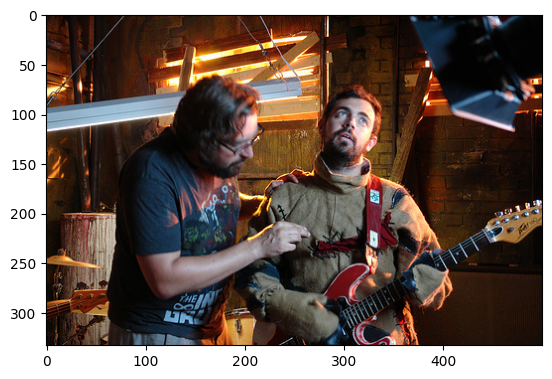

In [66]:

generate_caption('1000523639.jpg')